In [1]:
import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('GROK_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
DB = "products_vectorstore"

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# With train.pkl in this folder, you can run this:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

In [5]:
train[0]

<Delphi FG0166 Fuel Pump Module = $226.95>

In [6]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [7]:
client = chromadb.PersistentClient(path=DB)

In [8]:
# Check if the collection exists and delete it if it does
collection_name = "products"

# For old versions of Chroma, use this line instead of the subsequent one
# existing_collection_names = [collection.name for collection in client.list_collections()]
existing_collection_names = client.list_collections()

if collection_name in existing_collection_names:
    client.delete_collection(collection_name)
    print(f"Deleted existing collection: {collection_name}")

collection = client.create_collection(collection_name)

In [9]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [10]:
# Pass in a list of texts, get back a numpy array of vectors

vector = model.encode(["Well hi there"])[0]
vector.shape

(384,)

In [11]:
# Quick sidebar - extra to the videos - a function to compare vectors

import numpy as np
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def how_similar(text1, text2):
    vector1, vector2 = model.encode([text1, text2])
    similarity = cosine_similarity(vector1, vector2)
    print(f"Similarity between {text1} and {text2} is {similarity*100:.1f}%")

In [12]:
# And let's see how adding a few words to the context can change things up!

how_similar("Java", "C++")
how_similar("Java", "mug")
how_similar("Cup of Java", "mug")

Similarity between Java and C++ is 50.7%
Similarity between Java and mug is 25.8%
Similarity between Cup of Java and mug is 49.3%


In [13]:
# OK back to the main story - let's make something we can vectorize

def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [14]:
description(train[0])

'Delphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'

In [15]:
NUMBER_OF_DOCUMENTS = len(train)

# Uncomment if you'd rather not wait for the full 400,000
NUMBER_OF_DOCUMENTS = 20000

for i in tqdm(range(0, NUMBER_OF_DOCUMENTS, 1000)):
    documents = [description(item) for item in train[i: i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+len(documents))]
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas
    )

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]


In [23]:
#MAXIMUM_DATAPOINTS = 30_000 # 2D
MAXIMUM_DATAPOINTS = 20_000 # 3D

In [24]:
DB = "products_vectorstore"
client = chromadb.PersistentClient(path=DB)

In [25]:
collection = client.get_or_create_collection('products')

In [26]:
CATEGORIES = ['Appliances', 'Automotive', 'Cell_Phones_and_Accessories', 'Electronics','Musical_Instruments', 'Office_Products', 'Tools_and_Home_Improvement', 'Toys_and_Games']
COLORS = ['red', 'blue', 'brown', 'orange', 'yellow', 'green' , 'purple', 'cyan']

In [27]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [21]:
# Let's try a 2D chart

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

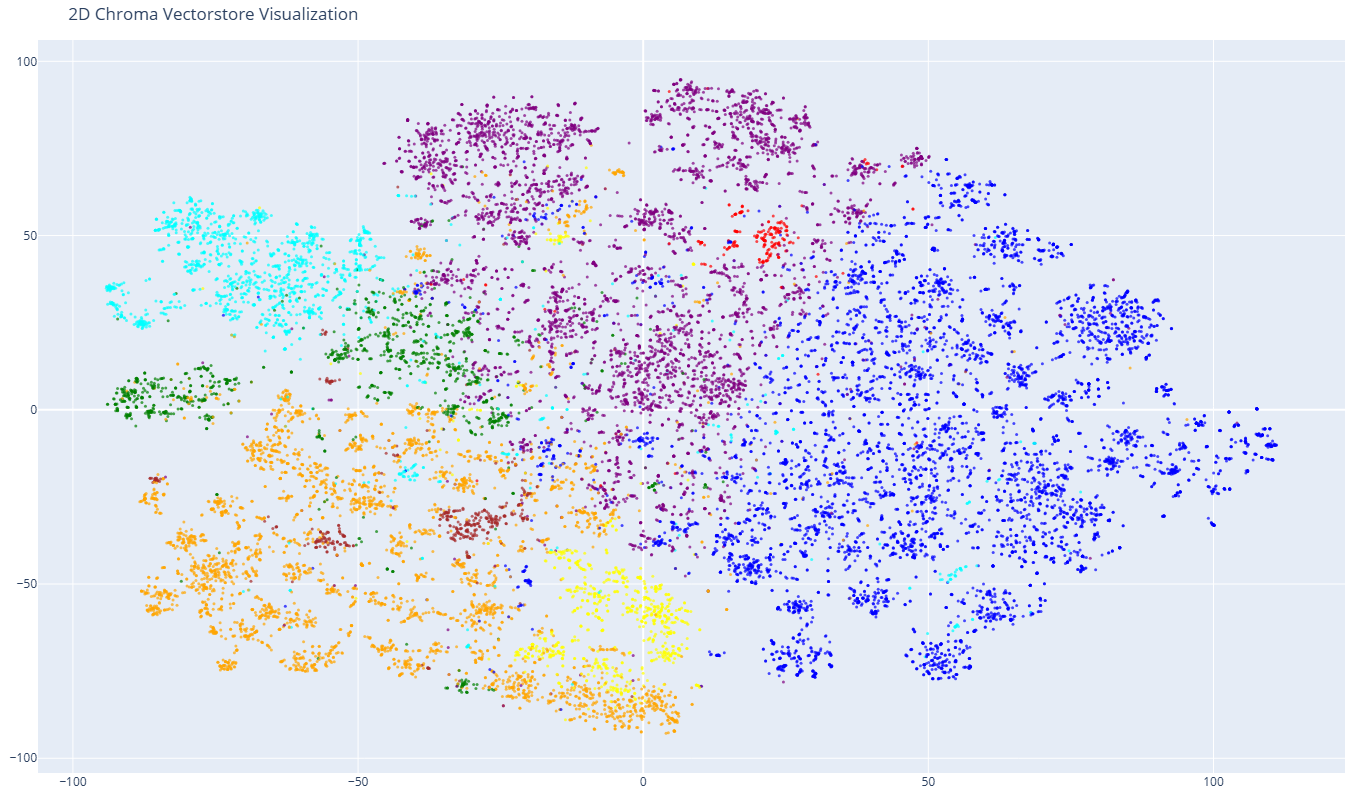

In [22]:

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [28]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

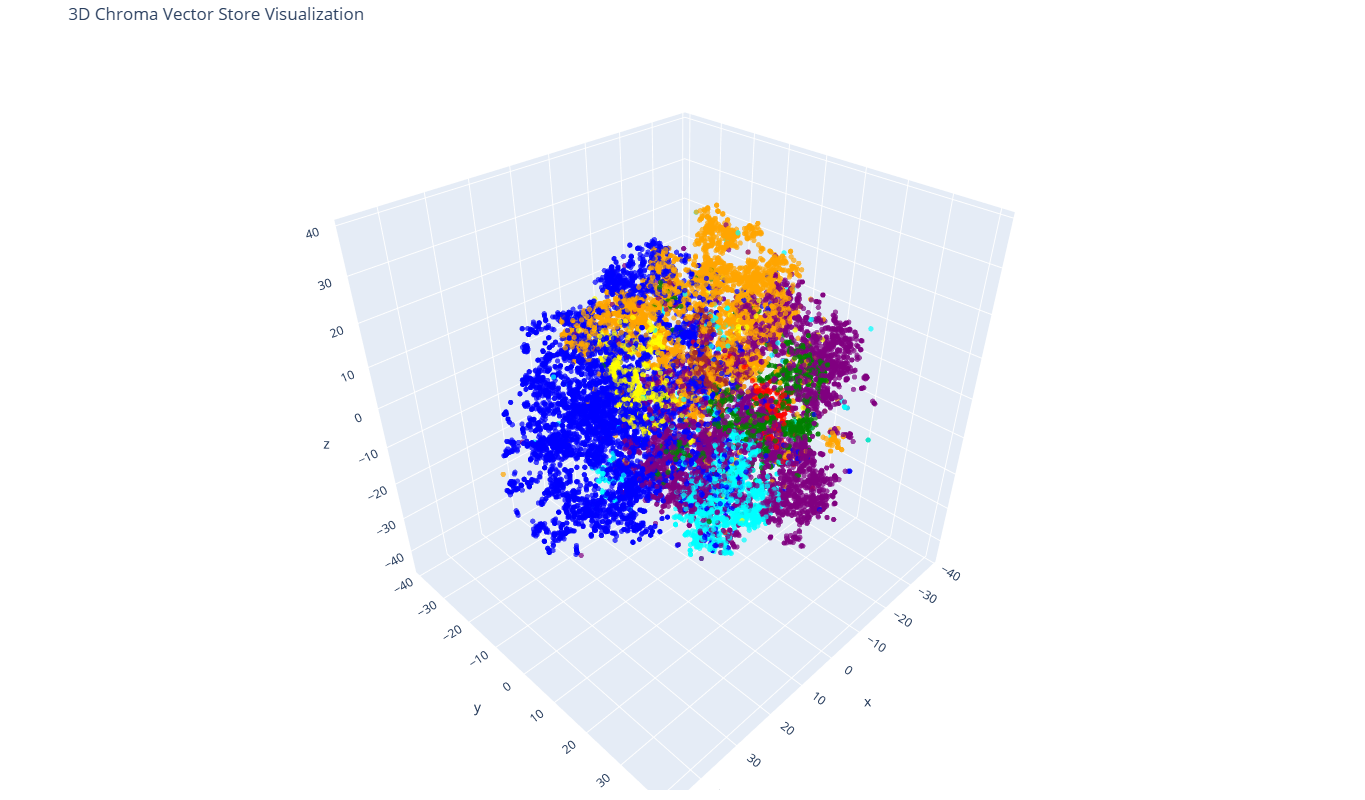

In [29]:

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()